In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
files = os.listdir("../Preprocess/GadgetX-NewMDCLUSTER-2/combined-csv/")
dfs = []

for file in files:
    file_path = os.path.join('../Preprocess/GadgetX-NewMDCLUSTER-2/combined-csv/', file)
    df = pd.read_csv(file_path)
    dfs.append(df)
    
df_all = pd.concat(dfs, ignore_index=True)

def str_to_list(s):
    # Remove brackets and split on commas
    elements = s.strip('[]').split(',')
    # Convert each element to an integer, ignoring empty strings
    return [int(e) for e in elements if e]

df_all['ProgenitorsID'] = df_all['ProgenitorsID'].apply(str_to_list)

df_all.head()

,hostHalo,numSubStruct,Mvir,npart,Xc,Yc,Zc,VXc,VYc,VZc,...,Ekin,Epot,SurfP,Phi0,cNFW,ID,numProgenitors,ProgenitorsID,redshift,snapshot
0,0,0,1.608690e+10,20,508049.266338,512691.650391,492890.133858,-71.57,-154.62,131.18,...,8.792180e+13,-2.217280e+14,-1.543680e+12,44848.4,12.38840,10000000000001,0,[-1],12.583,10
1,0,0,1.735600e+10,21,508041.024208,512672.722340,492907.255888,-59.43,-154.32,133.99,...,1.126410e+14,-2.357080e+14,-1.670860e+12,41203.6,9.33585,11000000000001,0,[-1],12.331,11
2,0,0,1.505410e+10,20,508051.990044,512661.980731,492896.650519,-85.68,-131.72,139.06,...,8.307170e+13,-1.729230e+14,-3.211000e+13,35588.5,-1.00000,12000000000001,0,[-1],11.962,12
3,0,0,2.623980e+10,28,508025.727102,512647.888490,492935.776711,-48.59,-131.73,155.67,...,2.330410e+14,-4.646660e+14,-1.536490e+14,58185.6,8.92696,13000000000001,0,[-1],11.722,13
4,0,0,1.711970e+10,20,476455.953717,493874.454498,499600.684643,230.13,100.87,178.62,...,1.429780e+14,-3.337170e+14,-2.584180e+13,69239.5,18.97090,13000000000002,0,[-1],11.722,13


In [3]:
def track_halo_history(halo_id, snapshot, df):
    halo = df[(df['ID'] == halo_id) & (df['snapshot'] == snapshot)]
    if len(halo) == 0:
        return pd.DataFrame()
    progenitors = halo.iloc[0]['ProgenitorsID']
    history = halo
    if progenitors:
        for progenitor in progenitors:
            if progenitor == -1:  # Ignore the progenitor if its ID is -1
                continue
            progenitor_history = track_halo_history(progenitor, snapshot - 1, df)
            history = pd.concat([history, progenitor_history])
    return history

In [4]:
def plot_halo_history(halo_id, halo_history):
    
    # Define font styles
    font_title = {'family': 'serif', 'color':  'black', 'weight': 'bold', 'size': 25}
    font_axes = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 25}
    font_legend = {'size': 14}
    
    plt.figure(figsize=(12, 8))
    
    # Getting current axis
    ax = plt.gca()

    merge_points = halo_history[halo_history['numProgenitors'] > 1]
    id_to_point = {row['ID']: (row['snapshot'], row['Mvir']) for _, row in halo_history.iterrows()}

    # Convert 'snapshot' column to integer
    halo_history['snapshot'] = halo_history['snapshot'].astype(int)

    # Identify final halo point
    final_halo_point = halo_history[halo_history['ID'] == halo_id].nlargest(1, 'snapshot')
    final_snapshot = final_halo_point['snapshot'].values[0]
    final_mvir = final_halo_point['Mvir'].values[0]

    # First, plot all lines connecting progenitors
    for _, row in halo_history.iterrows():
        for progenitor in row['ProgenitorsID']:
            if progenitor == -1 or progenitor not in id_to_point:
                continue
            x_values = [id_to_point[row['ID']][0], id_to_point[progenitor][0]]
            y_values = [id_to_point[row['ID']][1], id_to_point[progenitor][1]]
            line_color = 'red' if len(row['ProgenitorsID']) > 1 else 'grey'
            plt.plot(x_values, y_values, '--', color=line_color)

    # Then, plot all the points
    for halo_id, group in halo_history.groupby('ID'):
        plt.plot(group['snapshot'], group['Mvir'], 'o-', color='green', markersize=15)
        if halo_id in merge_points['ID'].values:
            merge_group = merge_points[merge_points['ID'] == halo_id]
            plt.plot(merge_group['snapshot'], merge_group['Mvir'], 'ro', markersize=15)

    # Mark the final halo point with a yellow color
    plt.plot(final_snapshot, final_mvir, 'yo', markersize=12)

    # Annotate the final halo point
    ax.annotate('Final Halo', 
                (final_snapshot, final_mvir), 
                textcoords="offset points", 
                xytext=(-15,-70), 
                ha='center',
                fontsize=18,
                arrowprops=dict(facecolor='black', arrowstyle='->'))
    
    first_merge_point = merge_points.iloc[-1]  # Get the last merge point
    ax.annotate('Merge Event', 
                (first_merge_point['snapshot'], first_merge_point['Mvir']), 
                textcoords="offset points", 
                xytext=(-25,40), 
                ha='center',
                fontsize=18,
                arrowprops=dict(facecolor='black', arrowstyle='->'))

    # Update label and title styles
    ax.set_xlabel('Snapshot', fontdict=font_axes)
    ax.set_ylabel(r'$M_{\mathrm{vir}} \, / \, 10^{11} M_{\odot}$', fontdict=font_axes)
    plt.title(f'Full History of Halo {halo_id}', fontdict=font_title, pad=10)
    
    # Increase the font size of tick labels
    ax.tick_params(axis='both', labelsize=20)
    
    # Set the legend
    ax.legend(fontsize=font_legend['size'])

    plt.show()

In [5]:
def plot_merger_tree(halo_history):

    G = nx.DiGraph()

    # Add nodes and edges to the graph based on the halo history
    for i, row in halo_history.iterrows():
        G.add_node((row['ID'], i), Mvir=row['Mvir'], snapshot=row['snapshot'])  # Use a tuple of (ID, index) to uniquely identify nodes
        for progenitor in row['ProgenitorsID']:
            if progenitor == -1:  # Ignore the progenitor if its ID is -1
                continue
            progenitor_rows = halo_history[(halo_history['ID'] == progenitor) & (halo_history['snapshot'] == row['snapshot'] - 1)]
            if progenitor_rows.empty:  # If the progenitor is not part of the tracked history, ignore it
                continue
            progenitor_index = progenitor_rows.index[0]
            # Highlight the edges where a merger occurs
            edge_color = 'red' if len(row['ProgenitorsID']) > 1 else 'grey'
            G.add_edge((progenitor, progenitor_index), (row['ID'], i), color=edge_color)  # Reverse the direction of the edges for the vertical plot

    # Assign a unique x-coordinate to each branch
    id_to_x = {}  # Do not start with the x-coordinate of the main halo
    next_x = 0  # The next x-coordinate to be assigned

    for node in nx.topological_sort(G):  # Iterate over the nodes in topological order
        if node not in id_to_x:  # If the node does not have an x-coordinate yet
            id_to_x[node] = next_x  # Assign the next x-coordinate to the node
            next_x += 1  # Increment the next x-coordinate
        for successor in G.successors(node):  # Iterate over the successors of the node
            if successor not in id_to_x:  # If the successor does not have an x-coordinate yet
                id_to_x[successor] = id_to_x[node]  # Assign the x-coordinate of the node to the successor
            elif G.edges[(node, successor)]['color'] == 'red':  # If a merger occurs
                # Adjust the x-coordinate of the successor to be closer to the x-coordinate of the node
                id_to_x[successor] = (id_to_x[successor] + id_to_x[node]) / 2

    # Find the final halo and its x-coordinate
    final_halo = (halo_history.iloc[0]['ID'], halo_history.iloc[0].name)
    final_halo_id = halo_history.iloc[0]['ID']
    final_halo_x = id_to_x[final_halo]

    # Find the midpoint of the x-coordinates
    min_x = min(id_to_x.values())
    max_x = max(id_to_x.values())
    midpoint_x = (min_x + max_x) / 2

    # Shift the x-coordinates so that the final halo is at the midpoint
    shift_x = midpoint_x - final_halo_x
    id_to_x = {node: x + shift_x for node, x in id_to_x.items()}

    # Normalize the x-coordinates to limit the width of the plot
    min_x = min(id_to_x.values())
    max_x = max(id_to_x.values())
    id_to_x = {node: 2 * (x - min_x) / (max_x - min_x) - 1 for node, x in id_to_x.items()}  # Normalize to the range [-1, 1]

    # Create a layered layout for the nodes, with each branch maintaining the same x-coordinate
    layered_pos = {node: (id_to_x[node], -G.nodes[node]['snapshot']) for node in G.nodes()}  # Reverse the y-coordinate for a top-to-bottom plot

    fig_width = 8
    fig_height = 12
    plt.figure(figsize=(fig_width, fig_height))

    # Draw the nodes
    node_colors = ['red' if node == final_halo else 'green' for node in G.nodes()]
    nx.draw_networkx_nodes(G, layered_pos, node_color=node_colors)

    # Draw the edges with color highlighting the merger edges
    edges = G.edges(data=True)
    edge_colors = [d['color'] for u, v, d in edges]
    nx.draw_networkx_edges(G, layered_pos, arrowstyle='->', arrowsize=10, edge_color=edge_colors)

    # Add labels to the nodes
    labels = {node: node[0] for node in G.nodes()}  # Only use the ID part of the (ID, index) tuple for the labels
    nx.draw_networkx_labels(G, layered_pos, labels=labels, font_size=5)

    plt.title(f'Merger Tree of Halo {final_halo_id}')
    plt.ylabel('Snapshot (Higher = Earlier)')
    plt.show()


In [6]:
def analyze_halo(halo_id):
    
    if halo_id not in df_all['ID'].values:
        print(f"Halo {halo_id} Cannot find halo.")
        return

    halo_snapshot = df_all[df_all['ID'] == halo_id].iloc[0]['snapshot']
    
    halo_history = track_halo_history(halo_id, halo_snapshot, df_all)

    #print(halo_history[['ID', 'snapshot', 'Mvir', 'numProgenitors', 'ProgenitorsID']])

    plot_halo_history(halo_id, halo_history)
    plot_merger_tree(halo_history)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


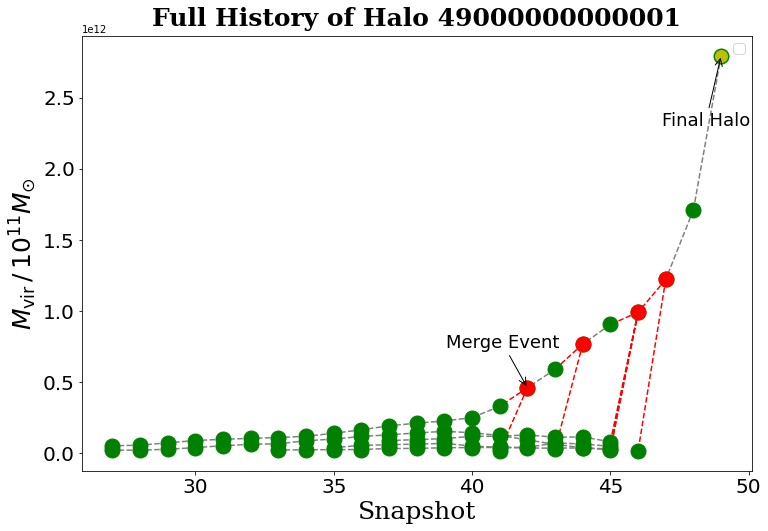

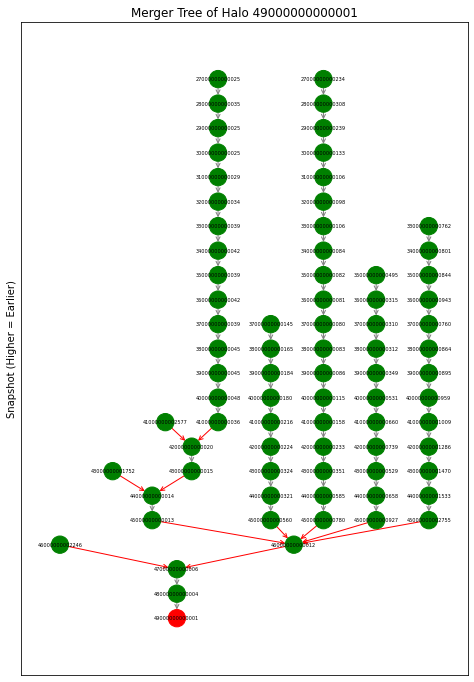

In [12]:
analyze_halo(49000000000001)